In [42]:
import numpy as np
import os
import pandas as pd
import geopandas as gpd
import altair as alt
import matplotlib.pyplot as plt
from spatial_access.Models import AccessCount, AccessModel, AccessSum, AccessTime
#https://colab.research.google.com/drive/1hFEU74iu_xTfT4rtZzsKw5f7OcClNGMt#scrollTo=MnPdB5LNyIJd
#https://colab.research.google.com/drive/16w5yiTyMx3hO5t6t0H-wa6fFlX41wPrb#scrollTo=zxuRInMy3b8Z
import itertools as iter
from itertools import groupby

from scipy.spatial import cKDTree
from shapely.geometry import Point

## Load Data

1. Read in: all US zip centroids

In [43]:
#origins for access calculation
origins = pd.read_csv("intermediateOrigins.csv") 
origins['GEOID'] = origins['GEOID'].astype(str).str.zfill(5)

In [44]:
zipCodes = gpd.read_file('contiguousUSZCTAs.gpkg')
zipCodes = zipCodes.rename(columns = {'GEOID10' : 'GEOID'})
zipCodes.head()

,ZCTA5CE10,GEOID,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,04757,04757,B5,G6350,S,334700805,3663844,+46.6676144,-068.1686355,"MULTIPOLYGON (((-68.08095 46.56746, -68.08236 ..."
1,04758,04758,B5,G6350,S,91006829,191946,+46.5592719,-067.8532254,"MULTIPOLYGON (((-67.90650 46.52526, -67.90677 ..."
2,04760,04760,B5,G6350,S,259787771,547534,+46.3393412,-067.9548745,"MULTIPOLYGON (((-67.85272 46.37207, -67.84753 ..."
3,04975,04975,B5,G6350,S,142318,0,+44.6253540,-069.5883338,"MULTIPOLYGON (((-69.58945 44.62188, -69.58938 ..."
4,04976,04976,B5,G6350,S,257908035,4722278,+44.7892800,-069.6676898,"MULTIPOLYGON (((-69.73503 44.78785, -69.73388 ..."


2. Read in: Destination MOUD Locations

In [98]:
year = 2010
keys_dict = np.load('../{}/keys.npy'.format(year), allow_pickle=True)
keys_dict.item()

{'SA': 'Substance abuse treatment services',
 'MH': 'Mental health services',
 'MH-SA': 'Mix of mental health and substance abuse services',
 'GH': 'General health services',
 'TX': 'Substance abuse treatment',
 'DT': 'Detoxifi cation',
 'MM': 'Methadone maintenance',
 'DM': 'Methadone detoxifi cation',
 'BU': 'Buprenorphine used in treatment',
 'HH': 'Halfway house',
 'HI': 'Hospital inpatient',
 'OP': 'Outpatient',
 'PH': 'Partial hospitalization/day treatment',
 'RS': 'Residential short-term treatment (30 days or fewer)',
 'RL': 'Residential long-term treatment (more than 30 days)',
 'AD': 'Adolescents',
 'CO': 'Persons with co-occurring mental and substance abuse disorders',
 'HV': 'Persons with HIV/AIDS',
 'GL': 'Gays and Lesbians',
 'SE': 'Seniors/older adults',
 'PW': 'Pregnant/postpartum women',
 'WN': 'Women',
 'MN': 'Men',
 'BC': 'Residential beds for clients’ children',
 'DU': 'DUI/DWI off enders',
 'CJ': 'Criminal justice clients',
 'SF': 'Self payment',
 'MD': 'Medicaid',


In [45]:
#this needs to be modified for MOUD with multiple drugs
#keys_dict = np.load('../{}/keys.npy'.format(year), allow_pickle=True)
def cat(keys):
    if 'MM' in keys:
        return 'Methadone'
#     if 'BU' in keys:
#         return 'Buprenorphine'
    return False

In [87]:
#take MM for example
year = 2015

#runs only 1 time
# dests = pd.read_csv('../{0}/{0}_g.csv'.format(year))
# dests = dests.rename(columns={"ID": "loc_ID"})
# dests.to_csv('../{0}/{0}_g.csv'.format(year), index = False)

dests = gpd.read_file('../{0}/{0}_g.csv'.format(year))

print('Length of {} raw data:'.format(year), len(dests))
dests['category'] = dests.Keys.apply(cat)
dests = dests[dests['category'] != False]
dests = dests.reset_index(drop=True)
#to gpd
dests = gpd.GeoDataFrame(dests, geometry=gpd.points_from_xy(dests.Longitude, dests.Latitude))
dests.head()

Length of 2015 raw data: 11928


,Name1,Name2,Name3,Address1,Address2,Address3,City,State,ZIP_Code,Contact,Note,Keys,loc_ID,Longitude,Latitude,Match Score,geometry,category
0,Shelby County Treatment Center,,,750 Highway 31 South,,,Alabaster,AL,35007,(205)216-0200,,SAF/SA/MM/BU/NXN/VTRL/OP/OMB/OIT/ORT/CT/SF/MD/...,4041AL35007,-86.78738528247351,33.21345712673533,100.0,POINT (-86.78739 33.21346),Methadone
1,Northwest Alabama Treatment Center,,,4204 Edmonton Drive,,,Bessemer,AL,35022,(205)425-1200,Methadone Clients Only,SAF/SA/MM/OTPA/OP/OMB/ORT/CT/SF/MD/SS/CO/GL/VE...,8772AL35022,-86.93995821612879,33.368655188646365,100.0,POINT (-86.93996 33.36866),Methadone
2,Birmingham Metro Treatment Center,,,151 Industrial Drive,,,Birmingham,AL,35211,(205)941-1799,Methadone and Buprenorphine Clients Only,SAF/SA/DT/MM/DM/BU/OTPA/OP/OD/OMB/SF/MD/YAD/AD...,3700AL35211,-86.85061106777306,33.44878773365579,100.0,POINT (-86.85061 33.44879),Methadone
3,Tri County Treatment Center,,,5605 Clifford Circle,,,Birmingham,AL,35210,(205)836-3345,Methadone and Buprenorphine Clients Only,SAF/SA/DT/MM/DM/BU/OTPA/OP/OD/OMB/ORT/CT/SF/MD...,3235AL35210,-86.63393643993608,33.583067121721314,100.0,POINT (-86.63394 33.58307),Methadone
4,Chilton County Treatment Center,,,2100 Holiday Inn Drive,,,Clanton,AL,35046,(205)755-4300,Methadone and Buprenorphine Clients Only,SAF/SA/MM/DM/BU/NXN/VTRL/OTPA/OP/OMB/ODT/ORT/C...,4113AL35046,-86.57907667258397,32.80903284317124,100.0,POINT (-86.57908 32.80903),Methadone


3. Combine geometry

In [47]:
#unify coordinate systems
dests.crs = "EPSG:4326"
zipCodes.geometry = zipCodes.geometry.to_crs(epsg = 4326)

In [20]:
#spatial join to include GEOID
destsOver = gpd.sjoin(dests, zipCodes[['GEOID', 'geometry']], how='inner', op='intersects')
##destsOver[destsOver['ZIP_Code'] != destsOver['GEOID']]: results in 205 rows

In [21]:
#Format destsOver
destsOver = destsOver.reset_index(drop=True) #reset index
destsOver['ID'] = destsOver.index + 1
destsOver = destsOver.drop(columns=['index_right'])
destsOver['GEOID'] = destsOver['GEOID'].astype(str)
print('Length of final {} data:'.format(year), len(destsOver))
destsOver.head()

Length of final 2015 data: 1093


,Name1,Name2,Name3,Address1,Address2,Address3,City,State,ZIP_Code,Contact,Note,Keys,loc_ID,Longitude,Latitude,Match Score,geometry,category,GEOID,ID
0,Shelby County Treatment Center,,,750 Highway 31 South,,,Alabaster,AL,35007,(205)216-0200,,SAF/SA/MM/BU/NXN/VTRL/OP/OMB/OIT/ORT/CT/SF/MD/...,4041AL35007,-86.78738528247351,33.21345712673533,100.0,POINT (-86.78739 33.21346),Methadone,35007,1
1,Northwest Alabama Treatment Center,,,4204 Edmonton Drive,,,Bessemer,AL,35022,(205)425-1200,Methadone Clients Only,SAF/SA/MM/OTPA/OP/OMB/ORT/CT/SF/MD/SS/CO/GL/VE...,8772AL35022,-86.93995821612879,33.368655188646365,100.0,POINT (-86.93996 33.36866),Methadone,35022,2
2,Birmingham Metro Treatment Center,,,151 Industrial Drive,,,Birmingham,AL,35211,(205)941-1799,Methadone and Buprenorphine Clients Only,SAF/SA/DT/MM/DM/BU/OTPA/OP/OD/OMB/SF/MD/YAD/AD...,3700AL35211,-86.85061106777306,33.44878773365579,100.0,POINT (-86.85061 33.44879),Methadone,35211,3
3,Tri County Treatment Center,,,5605 Clifford Circle,,,Birmingham,AL,35210,(205)836-3345,Methadone and Buprenorphine Clients Only,SAF/SA/DT/MM/DM/BU/OTPA/OP/OD/OMB/ORT/CT/SF/MD...,3235AL35210,-86.63393643993608,33.583067121721314,100.0,POINT (-86.63394 33.58307),Methadone,35210,4
4,Chilton County Treatment Center,,,2100 Holiday Inn Drive,,,Clanton,AL,35046,(205)755-4300,Methadone and Buprenorphine Clients Only,SAF/SA/MM/DM/BU/NXN/VTRL/OTPA/OP/OMB/ODT/ORT/C...,4113AL35046,-86.57907667258397,32.80903284317124,100.0,POINT (-86.57908 32.80903),Methadone,35046,5


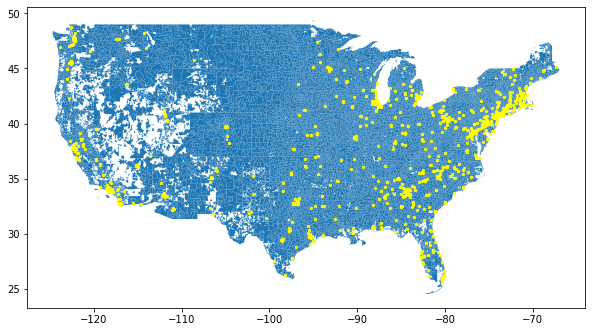

In [22]:
base = zipCodes.plot(figsize=(10,10))
destsOver.plot(ax=base, color='yellow', markersize = 2, figsize=(10,10))
plt.savefig('data{}/point_plot.png'.format(year), dpi = 300)

4. Import: Travel Cost Matrix

In [41]:
cost_matrix = pd.read_csv('US-ZCTA5-Travel-Time-Table.csv',dtype={'origin':str,'destination':str})
filtered_cost_matrix = cost_matrix[cost_matrix['origin'].astype(str).isin(origins.GEOID)]                                        
filtered_cost_matrix['destination'] = filtered_cost_matrix['destination'].astype(str)
cost_matrix_w_ids = filtered_cost_matrix.merge(destsOver[['ID', 'GEOID']], how='left', left_on='destination', right_on='GEOID')
cost_matrix_w_ids = cost_matrix_w_ids[~cost_matrix_w_ids.ID.isna()]
cost_matrix_w_ids = cost_matrix_w_ids.drop(columns=['destination','GEOID']).rename(columns={'ID':'destination'}) # drop extra columns
cost_matrix_w_ids.destination = cost_matrix_w_ids.destination.astype(int)
cost_matrix_w_ids.minutes = cost_matrix_w_ids.minutes.astype(float)
cost_matrix_w_ids.head()

/Users/olina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,origin,minutes,destination
10,01001,21.02,492
27,01001,19.88,502
33,01001,33.19,512
52,01001,21.93,522
67,01001,10.40,517


In [42]:
m_cost_matrix = cost_matrix_w_ids.pivot_table(index='origin', columns='destination', values='minutes', fill_value=999)
m_cost_matrix =  m_cost_matrix.reset_index().rename_axis(None, axis=1)
m_cost_matrix.origin = m_cost_matrix.origin.astype(str)
#m_cost_matrix

In [43]:
originsNotMatched = origins[~(origins.GEOID.isin(m_cost_matrix.origin))]
fillRows = pd.DataFrame(index = originsNotMatched.GEOID, columns = m_cost_matrix.columns[1:m_cost_matrix.shape[1]]).fillna(999)
fillRows = fillRows.reset_index().rename(columns={'GEOID':'origin'})
fillRows

m_cost_matrix = m_cost_matrix.append(fillRows)

In [44]:
destsNotMatched = destsOver[~(destsOver.ID.isin(m_cost_matrix.columns))]
fillColumns = pd.DataFrame(index = m_cost_matrix.index , columns = destsNotMatched.ID).fillna(999)
m_cost_matrix = pd.concat([m_cost_matrix,fillColumns],axis=1)
m_cost_matrix

,origin,1,2,3,4,5,6,7,8,9,...,1089,1090,1091,1092,1093,213,214,215,216,217
0,01001,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999,999,999,999,999
1,01002,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999,999,999,999,999
2,01003,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999,999,999,999,999
3,01005,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999,999,999,999,999
4,01007,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999,999,999,999,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4518,04735,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999,999,999,999,999
4519,04734,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999,999,999,999,999
4520,04732,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999,999,999,999,999
4521,04730,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,...,999.0,999.0,999.0,999.0,999.0,999,999,999,999,999


In [45]:
print('We started with', origins.shape[0],'origin zipcodes', sep =" ")
print('We started with', dests.shape[0], 'and were able to match',destsOver.shape[0],'locations', sep =" ")
print('Transformed cost matrix has', m_cost_matrix.shape[0], 'origins and', m_cost_matrix.shape[1]-1, 'destinations',sep = " ")

We started with 32604 origin zipcodes
We started with 1099 and were able to match 1093 locations
Transformed cost matrix has 32604 origins and 1093 destinations


- Save the files

In [46]:
destsOver.to_csv('data{}/destinations.csv'.format(year), index = False)
m_cost_matrix.to_csv('data{}/transformed_matrix.csv'.format(year), index = False)

# Run the access matrix

In [11]:
year = 2015

In [12]:
source_col_names = {'idx':'GEOID',
                    'population': 'skip',
                    'lon': 'X',
                    'lat': 'Y'}
dest_col_names   = {'idx':'ID',
                    'category': 'category',
                    'capacity': 'skip',
                    'lon': 'Longitude',
                    'lat': 'Latitude'}

In [13]:
accessT = AccessTime(network_type = 'drive',
                     transit_matrix_filename = 'data{}/transformed_matrix.csv'.format(year),
                     sources_filename = "intermediateOrigins.csv",
                     destinations_filename = 'data{}/destinations.csv'.format(year),
                     source_column_names = source_col_names,
                     dest_column_names = dest_col_names)              

In [14]:
accessT.transit_matrix.write_tmx('data{}/cost_matrix.tmx'.format(year))
accessT = AccessTime(network_type = 'drive',
                     transit_matrix_filename = 'data{}/cost_matrix.tmx'.format(year),
                     sources_filename = "intermediateOrigins.csv",
                     destinations_filename = 'data{}/destinations.csv'.format(year),
                     source_column_names = source_col_names,
                     dest_column_names = dest_col_names)  

INFO:spatial_access.p2p:Wrote to data2015/cost_matrix.tmx in 0.07 seconds


In [15]:
accessC = AccessCount(network_type = 'drive',
                     transit_matrix_filename = 'data{}/cost_matrix.tmx'.format(year),
                     sources_filename = "intermediateOrigins.csv",
                     destinations_filename = 'data{}/destinations.csv'.format(year),
                     source_column_names = source_col_names,
                     dest_column_names = dest_col_names)  

In [16]:
accessM = AccessModel(network_type = 'drive',
                     transit_matrix_filename = 'data{}/cost_matrix.tmx'.format(year),
                     sources_filename = "intermediateOrigins.csv",
                     destinations_filename = 'data{}/destinations.csv'.format(year),
                     source_column_names = source_col_names,
                     dest_column_names = dest_col_names,
                     decay_function= 'linear')

In [19]:
dests = pd.read_csv("data2015/destinations.csv")
weights = {}
for x in list(dests.category.unique()):
    weights[x] = [1,1,1]
weights

{'Methadone': [1, 1, 1]}

In [20]:
ttn = accessT.calculate()
ttn = ttn.reset_index()

In [21]:
ttn.head()

,index,time_to_nearest_Methadone,time_to_nearest_all_categories
0,99403,999,999
1,99402,999,999
2,99401,999,999
3,99371,118,118
4,99363,999,999


In [22]:
nCount = accessC.calculate(upper_threshold = 30)
nCount = nCount.reset_index()
accessNalViv = ttn.merge(nCount)

In [23]:
score = accessM.calculate(upper_threshold = 30, category_weight_dict = weights)
score = score.reset_index()
accessNalViv = accessNalViv.merge(score)

INFO:spatial_access.BaseModel:Using weights: {'Methadone': [1, 1, 1]}


In [24]:
accessNalViv

,index,time_to_nearest_Methadone,time_to_nearest_all_categories,count_in_range_Methadone,count_in_range_all_categories,all_categories_score,Methadone_score
0,99403,999,999,0,0,0.000000,0.000000
1,99402,999,999,0,0,0.000000,0.000000
2,99401,999,999,0,0,0.000000,0.000000
3,99371,118,118,0,0,0.000000,0.000000
4,99363,999,999,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...
32599,1007,25,25,1,1,0.166667,0.166667
32600,1005,39,39,0,0,0.000000,0.000000
32601,1003,20,20,3,3,0.366667,0.366667
32602,1002,18,18,2,2,0.500000,0.500000


In [ ]:
accessNalViv.drop(['time_to_nearest_all_categories','count_in_range_all_categories','all_categories_score'], axis=1, inplace=True)
accessNalViv = accessNalViv.rename(columns= {'index':'ZCTA'})
aaccessNalViv.to_csv('{}/access_final.csv'.format(year), index = False)

## Min distance

In [48]:
def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: ((x.x), (x.y)))))
    nB = np.array(list(gdB.geometry.apply(lambda x: ((x.x), (x.y)))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1, n_jobs =5) 
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns != 'geometry'].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1) # converting to miles if in degrees * 111/(0.001*1609
    return gdf

In [55]:
dests.geometry = dests.geometry.to_crs(epsg = 2163) # units = meters
origins.geometry = origins.geometry.to_crs(epsg = 2163)
minDist = dests.groupby('category').apply(lambda x :  ckdnearest(origins,  x.reset_index()))

AttributeError: 'Series' object has no attribute 'to_crs'

In [ ]:
minDist

In [ ]:
#minDist.drop(columns=['STATEFP','COUNTYFP','TRACTCE','POPULATION','centroidLongitude','centroidLatitude','index','category'], inplace= True)
minDist.drop(columns ='category',inplace=True)
minDist.dist = minDist.dist /1609 # to miles
minDist.loc[minDist.dist >50,'dist'] = np.nan
minDist.head()